# Resolución de Picross mediante Constraint Programming

## Parte 1: Picross

### Introducción al Problema

El **Picross** (también conocido como **Nonograma**) es un rompecabezas lógico donde se debe revelar una imagen oculta pintando celdas en una cuadrícula siguiendo restricciones numéricas.

### Reglas del Picross:
- Cada fila y columna tiene una secuencia de números (pistas)
- Cada número indica cuántas celdas consecutivas deben pintarse
- Entre grupos de celdas pintadas debe haber al menos una celda vacía
- El objetivo es satisfacer todas las restricciones simultáneamente

### Ejemplo a Resolver:
En este notebook resolveremos un Picross de **15x20** con las siguientes pistas:

**Pistas de Filas:**
- Fila 0: [1]
- Fila 1: [1]
- Fila 2: [1, 2]
- Fila 3: [2, 3, 4]
- Fila 4: [4, 3]
- Fila 5: [6, 3, 2]
- Fila 6: [5]
- Fila 7: [1, 3, 1]
- Fila 8: [2, 1, 5, 1]
- Fila 9: [1, 5, 7]
- Fila 10: [2, 4, 8]
- Fila 11: [6, 1, 4, 4]
- Fila 12: [3, 2, 1, 4, 3]
- Fila 13: [4, 4, 8]
- Fila 14: [20]

**Pistas de Columnas:**
- Columna 0: [2, 1, 1]
- Columna 1: [3, 1, 2]
- Columna 2: [2, 4]
- Columna 3: [2, 6]
- Columna 4: [1, 5]
- Columna 5: [1, 1, 1]
- Columna 6: [1, 6]
- Columna 7: [8]
- Columna 8: [2, 2]
- Columna 9: [6]
- Columna 10: [1, 2, 1]
- Columna 11: [6, 5]
- Columna 12: [15]
- Columna 13: [12]
- Columna 14: [1, 7]
- Columna 15: [1, 2, 2]
- Columna 16: [1, 6]
- Columna 17: [1, 8]
- Columna 18: [2, 1, 6]
- Columna 19: [1, 1, 1, 1]

In [1]:
#!pip install -U ortools -q
#%pip install -U ortools -q

In [2]:
# Importar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from ortools.sat.python import cp_model

In [3]:
# Definir las pistas del Picross
row_clues = [
    [1],        # Fila 0
    [1],     # Fila 1
    [1, 2],  # Fila 2
    [2, 3, 4],     # Fila 3
    [4, 3],         # Fila 4
    [6,3,2],    # Fila 5
    [5],    # Fila 6
    [1,3,1],    # Fila 7
    [2,1,5,1],  # Fila 8
    [1,5,7],    # Fila 9
    [2,4,8],    # Fila 10
    [6,1,4,4],  # Fila 11
    [3,2,1,4,3],# Fila 12
    [4,4,8],    # Fila 13
    [20]        # Fila 14
]

col_clues = [
    [2,1,1],  # Columna 0
    [3,1,2],  # Columna 1
    [2,4],     # Columna 2
    [2,6],  # Columna 3
    [1,5],   # Columna 4
    [1,1,1],
    [1,6],
    [8],
    [2,2],
    [6],
    [1,2,1],
    [6,5],
    [15],
    [12],
    [1,7],
    [1,2,2],
    [1,6],
    [1,8],
    [2,1,6],
    [1,1,1,1]
]

n_rows = len(row_clues)
n_cols = len(col_clues)

## Visualización del Tablero Vacío

A continuación se muestra el tablero vacío con las pistas que debemos satisfacer:

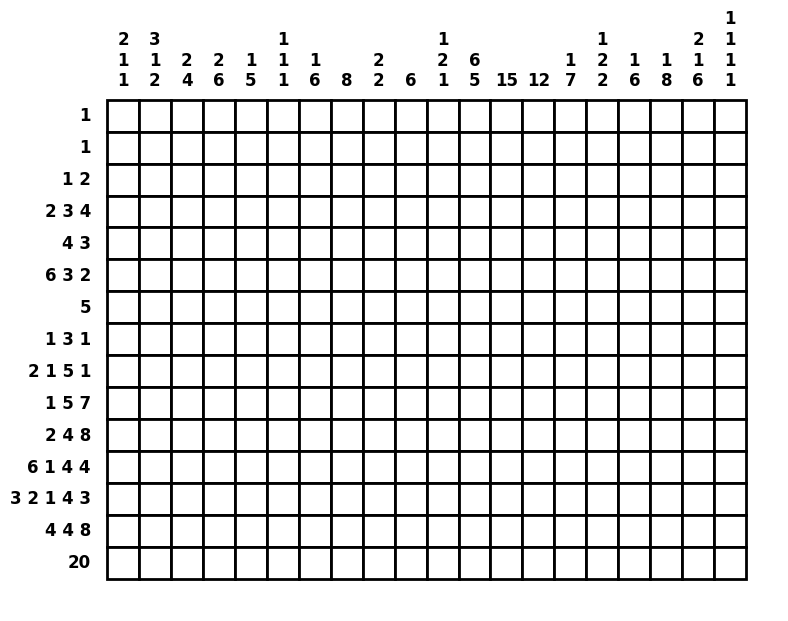

In [4]:
# Función para dibujar el tablero vacío con pistas
def draw_empty_board(row_clues, col_clues):
    """
    Dibuja el tablero vacío del Picross mostrando las pistas
    """
    n_rows = len(row_clues)
    n_cols = len(col_clues)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-1, n_cols + 1)
    ax.set_ylim(-1, n_rows + 1)
    ax.set_aspect('equal')
    ax.axis('off')

    # Dibujar las celdas vacías
    for i in range(n_rows):
        for j in range(n_cols):
            rect = plt.Rectangle((j, n_rows - 1 - i), 1, 1,
                                 facecolor='white', edgecolor='black', linewidth=2)
            ax.add_patch(rect)

    # Dibujar pistas de filas (a la izquierda)
    for i, clue in enumerate(row_clues):
        clue_text = ' '.join(map(str, clue))
        ax.text(-0.5, n_rows - 1 - i + 0.5, clue_text,
                ha='right', va='center', fontsize=12, fontweight='bold')

    # Dibujar pistas de columnas (arriba)
    for j, clue in enumerate(col_clues):
        clue_text = '\n'.join(map(str, clue))
        ax.text(j + 0.5, n_rows + 0.3, clue_text,
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Mostrar el tablero vacío
draw_empty_board(row_clues, col_clues)

## Funciones Auxiliares

### 1. Generación de Configuraciones Válidas

Esta función genera todas las posibles configuraciones de una línea (fila o columna) que satisfacen las pistas dadas.

In [5]:
def generate_line_patterns(length, clues):
    """
    Genera todas las configuraciones válidas para una línea dado su longitud y pistas.
    Similar a la función del Kakuro que genera tuplas válidas.

    Args:
        length: Longitud de la línea (número de celdas)
        clues: Lista de números que indican los grupos consecutivos

    Returns:
        Lista de tuplas, cada una representando una configuración válida (0=vacío, 1=pintado)
    """
    if not clues:
        return [tuple([0] * length)]

    patterns = []

    def backtrack(pos, clue_idx, current_pattern):
        # Si hemos colocado todos los grupos
        if clue_idx == len(clues):
            # Completar con ceros el resto
            patterns.append(tuple(current_pattern + [0] * (length - pos)))
            return

        clue = clues[clue_idx]
        min_space_needed = sum(clues[clue_idx:]) + (len(clues) - clue_idx - 1)

        # Intentar colocar el grupo en diferentes posiciones
        for start in range(pos, length - min_space_needed + 1):
            # Añadir ceros antes del grupo
            new_pattern = current_pattern + [0] * (start - pos) + [1] * clue

            # Si no es el último grupo, añadir al menos un cero de separación
            if clue_idx < len(clues) - 1:
                new_pattern.append(0)
                backtrack(start + clue + 1, clue_idx + 1, new_pattern)
            else:
                backtrack(start + clue, clue_idx + 1, new_pattern)

    backtrack(0, 0, [])
    return patterns

# Ejemplo de uso
example_patterns = generate_line_patterns(5, [1, 1])
print(f"Patrones válidos para longitud 5 con pistas [1, 1]:")
for i, pattern in enumerate(example_patterns):
    print(f"  Patrón {i+1}: {pattern}")

Patrones válidos para longitud 5 con pistas [1, 1]:
  Patrón 1: (1, 0, 1, 0, 0)
  Patrón 2: (1, 0, 0, 1, 0)
  Patrón 3: (1, 0, 0, 0, 1)
  Patrón 4: (0, 1, 0, 1, 0)
  Patrón 5: (0, 1, 0, 0, 1)
  Patrón 6: (0, 0, 1, 0, 1)


### 2. Modelo CSP del Picross

In [6]:
def solve_picross(row_clues, col_clues):
    """
    Resuelve un Picross usando Constraint Programming con OR-Tools.
    Basado en el enfoque del Kakuro y N-Queens vistos en clase.

    Args:
        row_clues: Lista de pistas para cada fila
        col_clues: Lista de pistas para cada columna

    Returns:
        Matriz numpy con la solución (0=vacío, 1=pintado) o None si no hay solución
    """
    n_rows = len(row_clues)
    n_cols = len(col_clues)

    # Crear el modelo
    model = cp_model.CpModel()

    # Crear variables: una por cada celda (0=vacío, 1=pintado)
    grid = {}
    for i in range(n_rows):
        for j in range(n_cols):
            grid[(i, j)] = model.NewIntVar(0, 1, f'cell_{i}_{j}')

    # Restricciones para las filas
    for i, clue in enumerate(row_clues):
        row_vars = [grid[(i, j)] for j in range(n_cols)]
        valid_patterns = generate_line_patterns(n_cols, clue)
        model.AddAllowedAssignments(row_vars, valid_patterns)

    # Restricciones para las columnas
    for j, clue in enumerate(col_clues):
        col_vars = [grid[(i, j)] for i in range(n_rows)]
        valid_patterns = generate_line_patterns(n_rows, clue)
        model.AddAllowedAssignments(col_vars, valid_patterns)

    # Resolver
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Extraer la solución
        solution = np.zeros((n_rows, n_cols), dtype=int)
        for i in range(n_rows):
            for j in range(n_cols):
                solution[i, j] = solver.Value(grid[(i, j)])
        return solution
    else:
        return None

# Resolver el Picross
solution = solve_picross(row_clues, col_clues)

if solution is not None:
    print("¡Solución encontrada!")
    print(solution)
else:
    print("No se encontró solución.")

¡Solución encontrada!
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0]
 [1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0]
 [1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0]
 [0 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0]
 [0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1]
 [0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0]
 [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


### 3. Visualización de la Solución

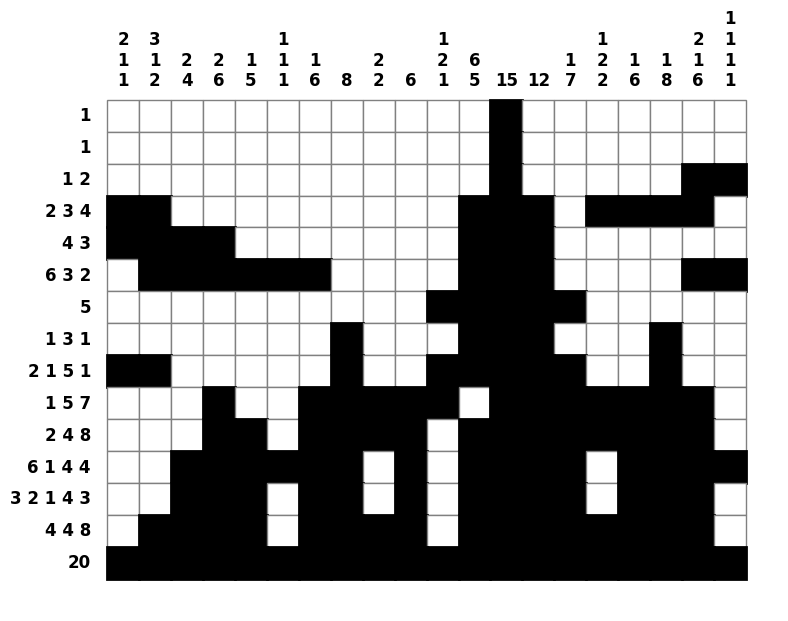

In [7]:
def draw_solution(solution, row_clues, col_clues):
    """
    Dibuja la solución del Picross.
    Basado en la visualización del N-Queens vista en clase.

    Args:
        solution: Matriz numpy con la solución
        row_clues: Pistas de las filas
        col_clues: Pistas de las columnas
    """
    n_rows, n_cols = solution.shape

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-1, n_cols + 1)
    ax.set_ylim(-1, n_rows + 1)
    ax.set_aspect('equal')
    ax.axis('off')

    # Dibujar las celdas
    for i in range(n_rows):
        for j in range(n_cols):
            if solution[i, j] == 1:
                # Celda pintada - negro
                rect = plt.Rectangle((j, n_rows - 1 - i), 1, 1,
                                     facecolor='black', edgecolor='black', linewidth=2)
            else:
                # Celda vacía - blanco con borde
                rect = plt.Rectangle((j, n_rows - 1 - i), 1, 1,
                                     facecolor='white', edgecolor='gray', linewidth=1)
            ax.add_patch(rect)

    # Dibujar pistas de filas
    for i, clue in enumerate(row_clues):
        clue_text = ' '.join(map(str, clue))
        ax.text(-0.5, n_rows - 1 - i + 0.5, clue_text,
                ha='right', va='center', fontsize=12, fontweight='bold')

    # Dibujar pistas de columnas
    for j, clue in enumerate(col_clues):
        clue_text = '\n'.join(map(str, clue))
        ax.text(j + 0.5, n_rows + 0.3, clue_text,
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Visualizar la solución
if solution is not None:
    draw_solution(solution, row_clues, col_clues)

## Referencias y Explicación de Funciones Utilizadas

### Funciones Base de Referencia:

#### 1. **Del archivo `20252_cst_pc1_u20221e167.ipynb` (Kakuro)**

**Función referenciada:** Generación de tuplas válidas y uso de `AddAllowedAssignments`

**Cambios realizados:**
- En el Kakuro, se generaban combinaciones de dígitos (1-9) que sumaban un valor específico
- En el Picross, se adapta la idea pero generando **patrones binarios** (0 y 1) que satisfacen las pistas de bloques consecutivos
- La función `generate_line_patterns()` es análoga a `valid_tuples_for()` del Kakuro, pero para patrones de Picross

**Similitud:** Ambos usan `model.AddAllowedAssignments()` para restringir las variables a configuraciones válidas pre-calculadas.

---

#### 2. **Del archivo `NQueens_AllDiff.ipynb`**

**Funciones referenciadas:**
- Creación del modelo con `cp_model.CpModel()`
- Definición de variables con `model.NewIntVar()`
- Uso de restricciones `AddAllDifferent()` (concepto de restricciones globales)
- Visualización con matplotlib

**Cambios realizados:**
- En N-Queens, se usan `AddAllDifferent()` para las reinas
- En Picross, no usamos `AddAllDifferent` pero sí aplicamos el mismo concepto de **variables con dominio** y **restricciones globales** mediante `AddAllowedAssignments`
- La función de visualización `draw_solution()` se inspira en `drawBoard()` del N-Queens, adaptándola para mostrar celdas pintadas vs vacías en lugar de reinas

---

### Conceptos Clave Aplicados:

1. **Variables de Dominio Binario:** Cada celda es 0 o 1 (vacía o pintada)
2. **Restricciones de Tabla:** Uso de `AddAllowedAssignments()` para limitar configuraciones válidas de filas y columnas
3. **Backtracking para generar patrones:** La función recursiva en `generate_line_patterns()` explora sistemáticamente todas las formas de colocar bloques
4. **Visualización gráfica:** Uso de matplotlib para representar el estado inicial y la solución final

---

### Diferencias con los Problemas de Referencia:

| Aspecto | Kakuro | N-Queens | Picross |
|---------|---------|----------|---------|
| **Variables** | Dígitos 1-9 | Posición de reinas | Binario 0-1 |
| **Restricción Principal** | Suma y AllDifferent | AllDifferent en diagonales | Patrones de bloques |
| **Técnica CSP** | AddAllowedAssignments | AddAllDifferent | AddAllowedAssignments |
| **Complejidad** | Alta (combinatoria) | Media (permutaciones) | Alta (exponencial en patrones) |

---

# Parte 2: Color Picross

## Introducción al Color Picross

El **Color Picross** (también conocido como **Nonograma de Colores**) es una extensión del Picross clásico que añade una dimensión adicional de complejidad: **múltiples colores**.

### ¿Qué diferencia al Color Picross del Picross tradicional?

En el Picross clásico trabajamos con dos estados: celda pintada (negro) o celda vacía (blanco). En el Color Picross, cada celda puede tener uno de **varios colores posibles**, o estar vacía.

### Reglas del Color Picross:

1. **Pistas con Colores**: Cada número en las pistas está asociado a un color específico
2. **Separación entre Grupos**: Entre grupos de celdas del **mismo color** debe haber al menos una celda vacía o de diferente color
3. **Grupos Consecutivos**: Los grupos de diferentes colores pueden estar adyacentes (sin espacios entre ellos)
4. **Orden Obligatorio**: Los grupos deben aparecer en el orden especificado por las pistas
5. **Celdas Vacías**: No todas las celdas deben estar pintadas; algunas permanecerán vacías

### Complejidad Adicional:

El Color Picross es significativamente más complejo que el Picross clásico porque:
- El espacio de búsqueda es mucho mayor (múltiples colores vs. binario)
- Las restricciones entre colores diferentes son más sutiles
- Requiere un modelado CSP más sofisticado

---

## Ejemplo a Resolver: Color Picross 15×15

Resolveremos un Color Picross de **15×15** con **4 colores**:
- 🔵 **Azul**
- 🟡 **Amarillo**
- 🟤 **Marrón**
- 🟨 **Crema**

### Pistas de Filas:

| Fila | Pistas |
|------|--------|
| **Fila 0** | 4 (azul) |
| **Fila 1** | 6 (azul) |
| **Fila 2** | 8 (azul) |
| **Fila 3** | 2 (crema), 2 (azul), 3 (crema), 1 (azul) |
| **Fila 4** | 1 (crema), 1 (azul), 2 (amarillo), 1 (crema), 1 (azul), 1 (crema), 1 (azul) |
| **Fila 5** | 1 (marrón), 4 (amarillo), 2 (marrón), 1 (azul) |
| **Fila 6** | 5 (marrón), 2 (azul) |
| **Fila 7** | 6 (crema), 3 (azul) |
| **Fila 8** | 1 (azul), 6 (crema), 4 (azul) |
| **Fila 9** | 2 (azul), 6 (crema), 5 (azul) |
| **Fila 10** | 3 (azul), 1 (marrón), 4 (crema), 1 (marrón), 2 (azul), 3 (azul) |
| **Fila 11** | 7 (marrón), 2 (azul) |
| **Fila 12** | 7 (marrón), 4 (azul) |
| **Fila 13** | 2 (marrón), 4 (marrón), 2 (azul) |
| **Fila 14** | 1 (amarillo), 1 (azul), 1 (amarillo), 1 (amarillo), 1 (azul), 1 (amarillo) |

### Pistas de Columnas:

| Columna | Pistas |
|---------|--------|
| **Columna 0** | 1 (azul) |
| **Columna 1** | 2 (azul) |
| **Columna 2** | 3 (azul) |
| **Columna 3** | 1 (azul), 2 (crema), 1 (marrón), 3 (crema), 3 (marrón), 1 (amarillo) |
| **Columna 4** | 2 (azul), 1 (crema), 1 (azul), 1 (amarillo), 1 (marrón), 4 (crema), 3 (marrón), 1 (azul) |
| **Columna 5** | 4 (azul), 2 (amarillo), 1 (marrón), 4 (crema), 3 (marrón), 1 (amarillo) |
| **Columna 6** | 4 (azul), 2 (amarillo), 1 (marrón), 4 (crema), 2 (marrón) |
| **Columna 7** | 3 (azul), 2 (crema), 1 (amarillo), 1 (marrón), 4 (crema), 3 (marrón) |
| **Columna 8** | 3 (azul), 1 (crema), 1 (azul), 2 (marrón), 3 (crema), 4 (marrón), 1 (amarillo) |
| **Columna 9** | 2 (azul), 2 (crema), 1 (marrón), 5 (azul), 3 (marrón), 1 (azul) |
| **Columna 10** | 11 (azul), 1 (marrón), 1 (amarillo) |
| **Columna 11** | 3 (azul), 3 (azul) |
| **Columna 12** | 3 (azul), 2 (azul) |
| **Columna 13** | 2 (azul), 1 (azul) |
| **Columna 14** | 1 (azul) |

---

### Reto de Modelado:

El desafío principal es adaptar nuestro enfoque CSP del Picross clásico para manejar:
1. **Variables multicolor**: En lugar de binarias (0-1), ahora tenemos dominio {0, 1, 2, 3, 4} representando (vacío, azul, amarillo, marrón, crema)
2. **Generación de patrones de colores**: Modificar `generate_line_patterns()` para soportar colores
3. **Restricciones más complejas**: Los grupos de colores diferentes pueden estar juntos, pero los del mismo color deben separarse

In [8]:
# Definir las pistas del Color Picross con colores
# Codificación: 0=vacío, 1=azul, 2=amarillo, 3=marrón, 4=crema

color_row_clues = [
    [(4, 1)],  # Fila 0: 4 azul
    [(6, 1)],  # Fila 1: 6 azul
    [(8, 1)],  # Fila 2: 8 azul
    [(2, 4), (2, 1), (3, 4), (1, 1)],  # Fila 3
    [(1, 4), (1, 1), (2, 2), (1, 4), (1, 1), (1, 4), (1, 1)],  # Fila 4
    [(1, 3), (4, 2), (2, 3), (1, 1)],  # Fila 5
    [(5, 3), (2, 1)],  # Fila 6
    [(6, 4), (3, 1)],  # Fila 7
    [(1, 1), (6, 4), (4, 1)],  # Fila 8
    [(2, 1), (6, 4), (5, 1)],  # Fila 9
    [(3, 1), (1, 3), (4, 4), (1, 3), (2, 1), (3, 1)],  # Fila 10
    [(7, 3), (2, 1)],  # Fila 11
    [(7, 3), (4, 1)],  # Fila 12
    [(2, 3), (4, 3), (2, 1)],  # Fila 13
    [(1, 2), (1, 1), (1, 2), (1, 2), (1, 1), (1, 2)]  # Fila 14
]

color_col_clues = [
    [(1, 1)],  # Columna 0
    [(2, 1)],  # Columna 1
    [(3, 1)],  # Columna 2
    [(1, 1), (2, 4), (1, 3), (3, 4), (3, 3), (1, 2)],  # Columna 3
    [(2, 1), (1, 4), (1, 1), (1, 2), (1, 3), (4, 4), (3, 3), (1, 1)],  # Columna 4
    [(4, 1), (2, 2), (1, 3), (4, 4), (3, 3), (1, 2)],  # Columna 5
    [(4, 1), (2, 2), (1, 3), (4, 4), (2, 3)],  # Columna 6
    [(3, 1), (2, 4), (1, 2), (1, 3), (4, 4), (3, 3)],  # Columna 7
    [(3, 1), (1, 4), (1, 1), (2, 3), (3, 4), (4, 3), (1, 2)],  # Columna 8
    [(2, 1), (2, 4), (1, 3), (5, 1), (3, 3), (1, 1)],  # Columna 9
    [(11, 1), (1, 3), (1, 2)],  # Columna 10
    [(3, 1), (3, 1)],  # Columna 11
    [(3, 1), (2, 1)],  # Columna 12
    [(2, 1), (1, 1)],  # Columna 13
    [(1, 1)]  # Columna 14
]

color_n_rows = len(color_row_clues)
color_n_cols = len(color_col_clues)

# Diccionario de colores para visualización
color_map = {
    0: 'white',      # vacío
    1: '#4169E1',    # azul
    2: '#FFD700',    # amarillo
    3: '#8B4513',    # marrón
    4: '#FFFACD'     # crema
}

color_names = {
    0: 'vacío',
    1: 'azul',
    2: 'amarillo',
    3: 'marrón',
    4: 'crema'
}

print(f"Color Picross configurado: {color_n_rows}×{color_n_cols}")
print(f"Colores disponibles: {len(color_map)} (incluyendo vacío)")
print(f"Total de pistas de filas: {sum(len(clue) for clue in color_row_clues)}")
print(f"Total de pistas de columnas: {sum(len(clue) for clue in color_col_clues)}")

Color Picross configurado: 15×15
Colores disponibles: 5 (incluyendo vacío)
Total de pistas de filas: 47
Total de pistas de columnas: 57


## Visualización del Tablero Vacío

A continuación se muestra el tablero vacío con las pistas de colores que debemos satisfacer:

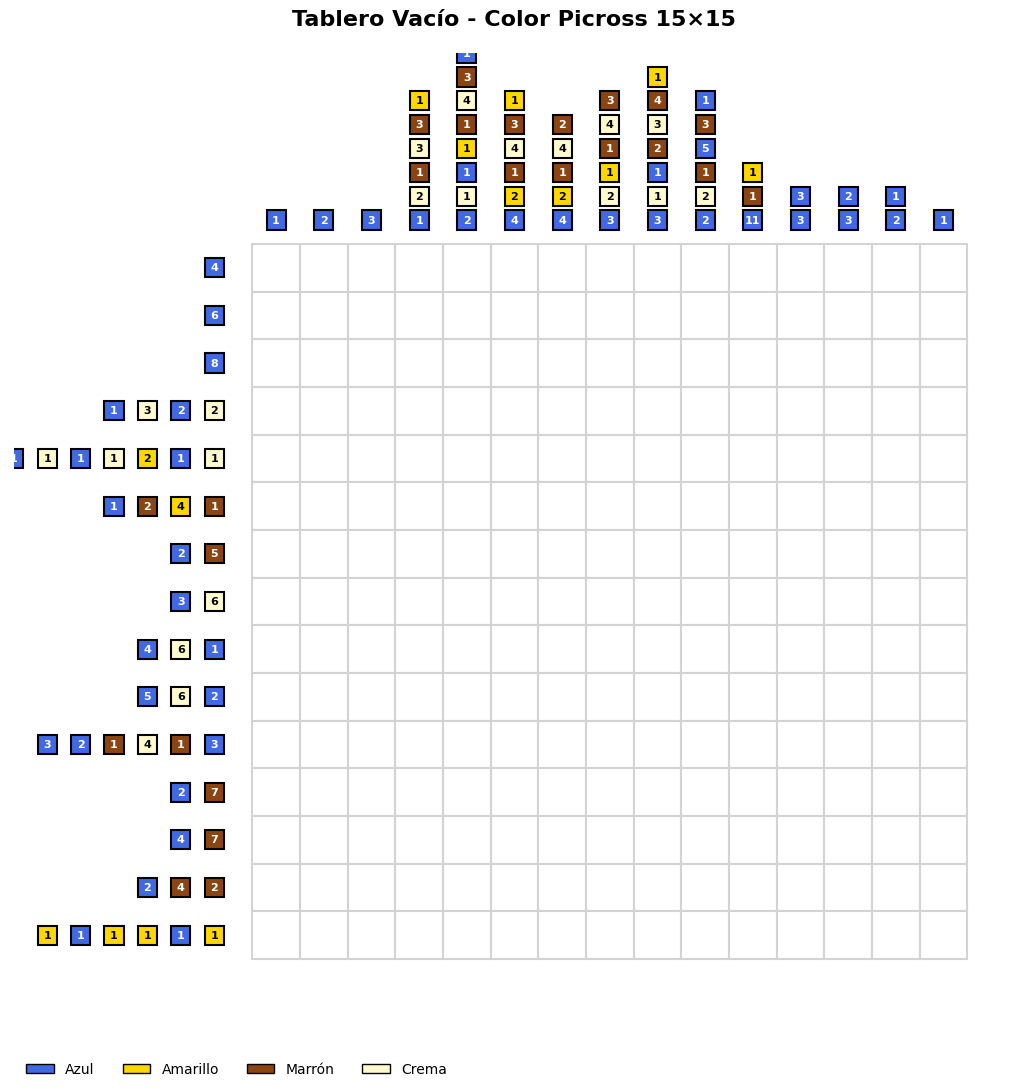

In [9]:
def draw_empty_color_board(row_clues, col_clues, color_map, color_names):
    """
    Dibuja el tablero vacío del Color Picross mostrando las pistas con colores.
    
    Args:
        row_clues: Pistas de las filas (lista de tuplas cantidad, color)
        col_clues: Pistas de las columnas (lista de tuplas cantidad, color)
        color_map: Diccionario con mapeo de valores a colores
        color_names: Diccionario con nombres de colores
    """
    n_rows = len(row_clues)
    n_cols = len(col_clues)

    fig, ax = plt.subplots(figsize=(16, 11))
    ax.set_xlim(-5, n_cols + 1)
    ax.set_ylim(-1.5, n_rows + 4)
    ax.set_aspect('equal')
    ax.axis('off')

    # Dibujar las celdas vacías
    for i in range(n_rows):
        for j in range(n_cols):
            rect = plt.Rectangle((j, n_rows - 1 - i), 1, 1,
                                 facecolor='white', edgecolor='lightgray', linewidth=1.5)
            ax.add_patch(rect)

    # Dibujar pistas de filas (a la izquierda) con colores
    for i, clue in enumerate(row_clues):
        x_offset = -0.5
        for count, color in clue:
            color_hex = color_map[color]
            color_name = color_names[color]
            # Dibujar pequeño cuadrado con el color
            small_rect = plt.Rectangle((x_offset - 0.5, n_rows - 1 - i + 0.3), 0.4, 0.4,
                                       facecolor=color_hex, edgecolor='black', linewidth=1.5)
            ax.add_patch(small_rect)
            # Añadir el número
            ax.text(x_offset - 0.3, n_rows - 1 - i + 0.5, str(count),
                    ha='center', va='center', fontsize=8, fontweight='bold', color='white' if color in [1, 3] else 'black')
            x_offset -= 0.7

    # Dibujar pistas de columnas (arriba) con colores
    for j, clue in enumerate(col_clues):
        y_offset = n_rows + 0.3
        for count, color in clue:
            color_hex = color_map[color]
            # Dibujar pequeño cuadrado con el color
            small_rect = plt.Rectangle((j + 0.3, y_offset), 0.4, 0.4,
                                       facecolor=color_hex, edgecolor='black', linewidth=1.5)
            ax.add_patch(small_rect)
            # Añadir el número
            ax.text(j + 0.5, y_offset + 0.2, str(count),
                    ha='center', va='center', fontsize=8, fontweight='bold', color='white' if color in [1, 3] else 'black')
            y_offset += 0.5
    
    # Agregar leyenda de colores
    legend_elements = []
    for color_val in [1, 2, 3, 4]:
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, 
                                            facecolor=color_map[color_val], 
                                            edgecolor='black',
                                            label=color_names[color_val].capitalize()))
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, -0.02), 
              ncol=4, frameon=False, fontsize=10)
    
    plt.title('Tablero Vacío - Color Picross 15×15', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# Mostrar el tablero vacío
draw_empty_color_board(color_row_clues, color_col_clues, color_map, color_names)

## Funciones Auxiliares para Color Picross

### 1. Generación de Configuraciones Válidas con Colores

Esta función genera todas las posibles configuraciones de una línea (fila o columna) que satisfacen las pistas de colores. A diferencia del Picross clásico, aquí debemos manejar:
- Múltiples colores (no solo binario)
- Grupos del mismo color deben estar separados por al menos una celda vacía o de otro color
- Grupos de colores diferentes pueden estar juntos (sin espacios obligatorios)

In [10]:
def generate_color_line_patterns(length, color_clues):
    """
    Genera todas las configuraciones válidas para una línea con múltiples colores.
    
    Args:
        length: Longitud de la línea (número de celdas)
        color_clues: Lista de tuplas (cantidad, color) donde color es 1=azul, 2=amarillo, 3=marrón, 4=crema
        
    Returns:
        Lista de tuplas, cada una representando una configuración válida
        (0=vacío, 1=azul, 2=amarillo, 3=marrón, 4=crema)
    """
    if not color_clues:
        return [tuple([0] * length)]
    
    patterns = []
    
    def backtrack(pos, clue_idx, current_pattern):
        # Si hemos colocado todos los grupos
        if clue_idx == len(color_clues):
            # Completar con ceros el resto
            patterns.append(tuple(current_pattern + [0] * (length - pos)))
            return
        
        count, color = color_clues[clue_idx]
        
        # Calcular espacio mínimo necesario para los grupos restantes
        min_space_needed = sum(c for c, _ in color_clues[clue_idx:])
        
        # Calcular espacios obligatorios entre grupos del mismo color
        gaps_needed = 0
        for i in range(clue_idx + 1, len(color_clues)):
            # Si el grupo anterior es del mismo color, necesitamos al menos 1 espacio
            if color_clues[i-1][1] == color_clues[i][1]:
                gaps_needed += 1
        
        # Intentar colocar el grupo en diferentes posiciones
        for start in range(pos, length - min_space_needed - gaps_needed + 1):
            # Añadir ceros antes del grupo
            new_pattern = current_pattern + [0] * (start - pos) + [color] * count
            
            # Determinar si necesitamos espacio obligatorio después
            if clue_idx < len(color_clues) - 1:
                next_color = color_clues[clue_idx + 1][1]
                if color == next_color:
                    # Mismo color: obligatorio al menos un espacio
                    new_pattern.append(0)
                    backtrack(start + count + 1, clue_idx + 1, new_pattern)
                else:
                    # Colores diferentes: pueden estar juntos o separados
                    # Opción 1: juntos
                    backtrack(start + count, clue_idx + 1, new_pattern)
                    # Opción 2: con espacio
                    backtrack(start + count + 1, clue_idx + 1, new_pattern + [0])
            else:
                # Último grupo
                backtrack(start + count, clue_idx + 1, new_pattern)
    
    backtrack(0, 0, [])
    return patterns

# Probar la función con un ejemplo simple
test_patterns = generate_color_line_patterns(5, [(1, 1), (1, 2)])
print(f"Patrones válidos para longitud 5 con pistas [(1, azul), (1, amarillo)]:")
print(f"Total de patrones generados: {len(test_patterns)}")
for i, pattern in enumerate(test_patterns[:10]):  # Mostrar solo los primeros 10
    pattern_str = ''.join(['□' if c == 0 else '■' for c in pattern])
    colors_str = ''.join([color_names[c][0].upper() if c != 0 else '·' for c in pattern])
    print(f"  {i+1}: {pattern_str} → {colors_str} {pattern}")
if len(test_patterns) > 10:
    print(f"  ... y {len(test_patterns) - 10} patrones más")

Patrones válidos para longitud 5 con pistas [(1, azul), (1, amarillo)]:
Total de patrones generados: 16
  1: ■■□□□ → AA··· (1, 2, 0, 0, 0)
  2: ■□■□□ → A·A·· (1, 0, 2, 0, 0)
  3: ■□□■□ → A··A· (1, 0, 0, 2, 0)
  4: ■□□□■ → A···A (1, 0, 0, 0, 2)
  5: ■□■□□ → A·A·· (1, 0, 2, 0, 0)
  6: ■□□■□ → A··A· (1, 0, 0, 2, 0)
  7: ■□□□■ → A···A (1, 0, 0, 0, 2)
  8: □■■□□ → ·AA·· (0, 1, 2, 0, 0)
  9: □■□■□ → ·A·A· (0, 1, 0, 2, 0)
  10: □■□□■ → ·A··A (0, 1, 0, 0, 2)
  ... y 6 patrones más


### 2. Modelo CSP del Color Picross

In [11]:
def solve_color_picross(row_clues, col_clues):
    """
    Resuelve un Color Picross usando Constraint Programming con OR-Tools.
    
    Args:
        row_clues: Lista de pistas para cada fila (tuplas de cantidad, color)
        col_clues: Lista de pistas para cada columna (tuplas de cantidad, color)
        
    Returns:
        Matriz numpy con la solución (0=vacío, 1-4=colores) o None si no hay solución
    """
    n_rows = len(row_clues)
    n_cols = len(col_clues)
    
    print(f"Iniciando resolución de Color Picross {n_rows}×{n_cols}...")
    
    # Crear el modelo
    model = cp_model.CpModel()
    
    # Crear variables: una por cada celda (0=vacío, 1=azul, 2=amarillo, 3=marrón, 4=crema)
    grid = {}
    for i in range(n_rows):
        for j in range(n_cols):
            grid[(i, j)] = model.NewIntVar(0, 4, f'cell_{i}_{j}')
    
    print("Variables creadas...")
    
    # Restricciones para las filas
    print("Generando restricciones de filas...")
    for i, clue in enumerate(row_clues):
        row_vars = [grid[(i, j)] for j in range(n_cols)]
        valid_patterns = generate_color_line_patterns(n_cols, clue)
        print(f"  Fila {i}: {len(valid_patterns)} patrones válidos")
        model.AddAllowedAssignments(row_vars, valid_patterns)
    
    # Restricciones para las columnas
    print("Generando restricciones de columnas...")
    for j, clue in enumerate(col_clues):
        col_vars = [grid[(i, j)] for i in range(n_rows)]
        valid_patterns = generate_color_line_patterns(n_rows, clue)
        print(f"  Columna {j}: {len(valid_patterns)} patrones válidos")
        model.AddAllowedAssignments(col_vars, valid_patterns)
    
    # Resolver
    print("\nResolviendo el modelo...")
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = 300.0  # Límite de 5 minutos
    
    status = solver.Solve(model)
    
    print(f"\nEstado de la solución: {solver.StatusName(status)}")
    print(f"Tiempo de resolución: {solver.WallTime():.2f} segundos")
    
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Extraer la solución
        solution = np.zeros((n_rows, n_cols), dtype=int)
        for i in range(n_rows):
            for j in range(n_cols):
                solution[i, j] = solver.Value(grid[(i, j)])
        return solution
    else:
        return None

# Resolver el Color Picross
print("="*60)
color_solution = solve_color_picross(color_row_clues, color_col_clues)
print("="*60)

if color_solution is not None:
    print("\n✅ ¡Solución encontrada!")
    print(f"Dimensiones: {color_solution.shape}")
    print(f"\nPrimeras 5 filas de la solución:")
    print(color_solution[:5])
else:
    print("\n❌ No se encontró solución.")

Iniciando resolución de Color Picross 15×15...
Variables creadas...
Generando restricciones de filas...
  Fila 0: 12 patrones válidos
  Fila 1: 10 patrones válidos
  Fila 2: 8 patrones válidos
  Fila 3: 1408 patrones válidos
  Fila 4: 34232 patrones válidos
  Fila 5: 1408 patrones válidos
  Fila 6: 81 patrones válidos
  Fila 7: 49 patrones válidos
  Fila 8: 85 patrones válidos
  Fila 9: 19 patrones válidos
  Fila 10: 1 patrones válidos
  Fila 11: 49 patrones válidos
  Fila 12: 25 patrones válidos
  Fila 13: 140 patrones válidos
  Fila 14: 17469 patrones válidos
Generando restricciones de columnas...
  Columna 0: 15 patrones válidos
  Columna 1: 14 patrones válidos
  Columna 2: 13 patrones válidos
  Columna 3: 985 patrones válidos
  Columna 4: 16 patrones válidos
  Columna 5: 1 patrones válidos
  Columna 6: 51 patrones válidos
  Columna 7: 12 patrones válidos
  Columna 8: 1 patrones válidos
  Columna 9: 12 patrones válidos
  Columna 10: 19 patrones válidos
  Columna 11: 45 patrones váli

### 3. Visualización de la Solución del Color Picross

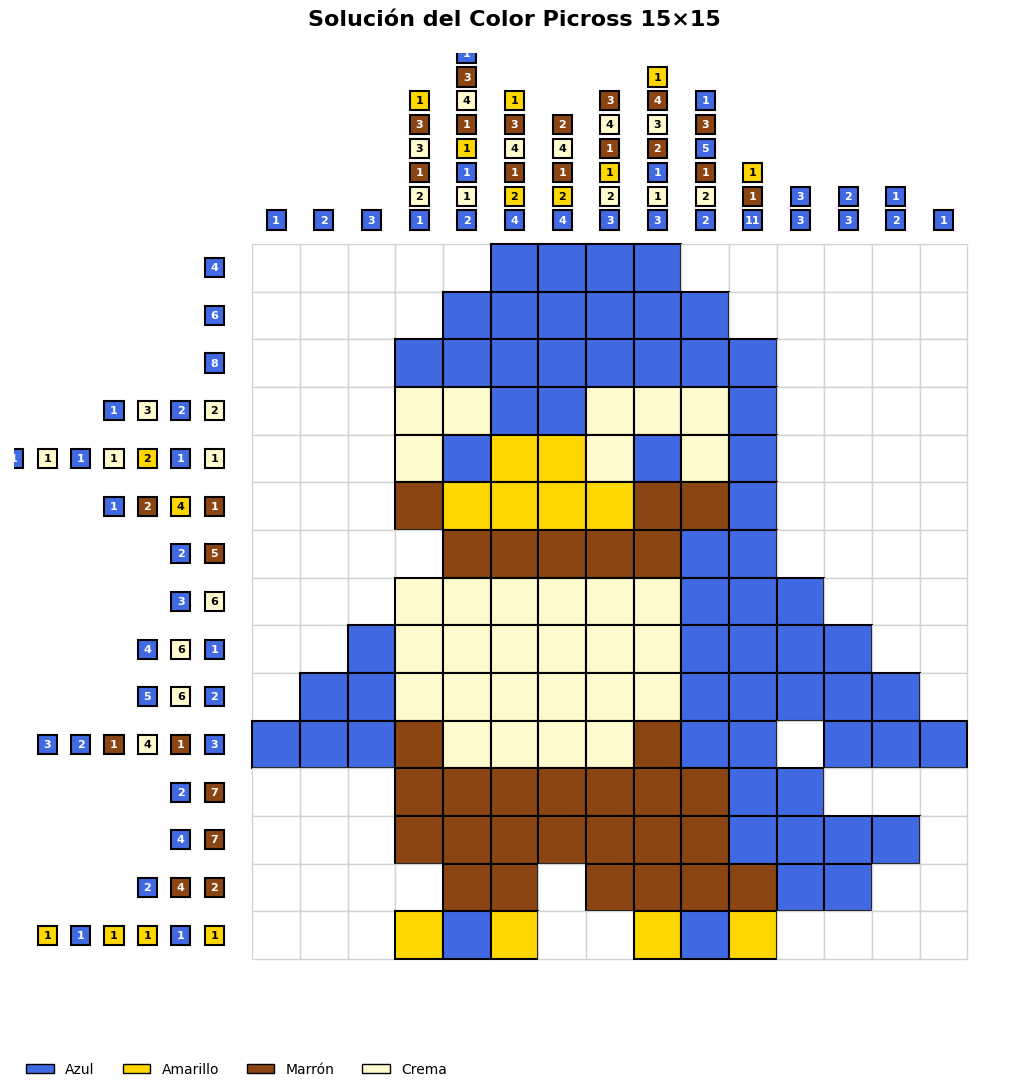

In [12]:
def draw_color_solution(solution, row_clues, col_clues, color_map, color_names):
    """
    Dibuja la solución del Color Picross.
    
    Args:
        solution: Matriz numpy con la solución (valores 0-4)
        row_clues: Pistas de las filas
        col_clues: Pistas de las columnas
        color_map: Diccionario con mapeo de valores a colores
        color_names: Diccionario con nombres de colores
    """
    n_rows, n_cols = solution.shape
    
    fig, ax = plt.subplots(figsize=(16, 11))
    ax.set_xlim(-5, n_cols + 1)
    ax.set_ylim(-1.5, n_rows + 4)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Dibujar las celdas
    for i in range(n_rows):
        for j in range(n_cols):
            cell_value = solution[i, j]
            cell_color = color_map[cell_value]
            
            if cell_value == 0:
                # Celda vacía - blanco con borde gris
                rect = plt.Rectangle((j, n_rows - 1 - i), 1, 1,
                                     facecolor='white', edgecolor='lightgray', linewidth=1)
            else:
                # Celda pintada con color
                rect = plt.Rectangle((j, n_rows - 1 - i), 1, 1,
                                     facecolor=cell_color, edgecolor='black', linewidth=1.5)
            ax.add_patch(rect)
    
    # Dibujar pistas de filas con cuadrados de colores
    for i, clue in enumerate(row_clues):
        x_offset = -0.5
        for count, color in clue:
            color_hex = color_map[color]
            # Dibujar pequeño cuadrado con el color
            small_rect = plt.Rectangle((x_offset - 0.5, n_rows - 1 - i + 0.3), 0.4, 0.4,
                                       facecolor=color_hex, edgecolor='black', linewidth=1.5)
            ax.add_patch(small_rect)
            # Añadir el número
            ax.text(x_offset - 0.3, n_rows - 1 - i + 0.5, str(count),
                    ha='center', va='center', fontsize=8, fontweight='bold', 
                    color='white' if color in [1, 3] else 'black')
            x_offset -= 0.7
    
    # Dibujar pistas de columnas con cuadrados de colores
    for j, clue in enumerate(col_clues):
        y_offset = n_rows + 0.3
        for count, color in clue:
            color_hex = color_map[color]
            # Dibujar pequeño cuadrado con el color
            small_rect = plt.Rectangle((j + 0.3, y_offset), 0.4, 0.4,
                                       facecolor=color_hex, edgecolor='black', linewidth=1.5)
            ax.add_patch(small_rect)
            # Añadir el número
            ax.text(j + 0.5, y_offset + 0.2, str(count),
                    ha='center', va='center', fontsize=8, fontweight='bold', 
                    color='white' if color in [1, 3] else 'black')
            y_offset += 0.5
    
    # Agregar leyenda de colores
    legend_elements = []
    for color_val in [1, 2, 3, 4]:
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, 
                                            facecolor=color_map[color_val], 
                                            edgecolor='black',
                                            label=color_names[color_val].capitalize()))
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, -0.02), 
              ncol=4, frameon=False, fontsize=10)
    
    plt.title('Solución del Color Picross 15×15', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# Visualizar la solución
if color_solution is not None:
    draw_color_solution(color_solution, color_row_clues, color_col_clues, color_map, color_names)
else:
    print("No hay solución para visualizar.")

## Explicación del Código de Color Picross

### Nuevas Adiciones y Cambios Principales

#### 1. **Estructura de Datos para Colores**

```python
# Pistas con tuplas (cantidad, color)
color_row_clues = [
    [(4, 1)],  # 4 celdas azules
    [(2, 4), (2, 1)],  # 2 crema, 2 azul
    ...
]
```

**Diferencia clave:** En lugar de simples números, cada pista es una tupla `(cantidad, color)` donde:
- `cantidad`: número de celdas consecutivas
- `color`: identificador del color (1=azul, 2=amarillo, 3=marrón, 4=crema, 0=vacío)

#### 2. **Función `generate_color_line_patterns()` - Extensión Multicolor**

**Adaptaciones principales:**

```python
def generate_color_line_patterns(length, color_clues):
    # Nueva lógica para manejar colores
    count, color = color_clues[clue_idx]  # Desempaquetar tupla
    
    # Determinar separación según colores
    if color == next_color:
        # MISMO COLOR: separación obligatoria
        new_pattern.append(0)
        backtrack(start + count + 1, clue_idx + 1, new_pattern)
    else:
        # COLORES DIFERENTES: pueden estar juntos O separados
        backtrack(start + count, clue_idx + 1, new_pattern)  # Juntos
        backtrack(start + count + 1, clue_idx + 1, new_pattern + [0])  # Separados
```

**Diferencias con Picross clásico:**
- **Picross clásico:** Todos los grupos deben separarse (mismo "color" negro)
- **Color Picross:** Solo grupos del mismo color requieren separación obligatoria
- **Ramificación adicional:** Cuando los colores son diferentes, se exploran ambas opciones (juntos/separados)

#### 3. **Variables con Dominio Extendido**

```python
# Picross clásico: dominio binario
grid[(i, j)] = model.NewIntVar(0, 1, f'cell_{i}_{j}')  # 0=vacío, 1=pintado

# Color Picross: dominio multicolor
grid[(i, j)] = model.NewIntVar(0, 4, f'cell_{i}_{j}')  # 0=vacío, 1-4=colores
```

**Impacto:** El espacio de búsqueda aumenta exponencialmente (2^n → 5^n posibilidades por celda)

#### 4. **Visualización Mejorada con Cuadrados de Colores**

```python
# Dibujar pistas con cuadrados de colores
for count, color in clue:
    color_hex = color_map[color]
    small_rect = plt.Rectangle((x_offset - 0.5, y + 0.3), 0.4, 0.4,
                               facecolor=color_hex, edgecolor='black')
    ax.add_patch(small_rect)
    # Texto contrastante (blanco para fondos oscuros)
    ax.text(x, y, str(count), color='white' if color in [1, 3] else 'black')
```

**Mejoras visuales:**
- Cuadrados coloreados en lugar de texto abreviado
- Contraste automático del texto según fondo
- Canvas ampliado para mejor visibilidad

---

## Comparación: Picross vs Color Picross

| Aspecto | Picross Clásico | Color Picross |
|---------|-----------------|---------------|
| **Dominio de Variables** | Binario: {0, 1} | Multicolor: {0, 1, 2, 3, 4} |
| **Espacio de Búsqueda** | 2^(n×m) | 5^(n×m) |
| **Estructura de Pistas** | `[3, 2, 1]` (números simples) | `[(3,1), (2,4), (1,2)]` (tuplas cantidad-color) |
| **Regla de Separación** | Todos los grupos deben separarse | Solo grupos del **mismo color** deben separarse |
| **Grupos Adyacentes** | ❌ Prohibido | ✅ Permitido si son de diferente color |
| **Complejidad de Generación** | O(2^k) patrones posibles | O(3^k) - O(4^k) patrones posibles* |
| **Visualización** | Blanco/Negro | 4 colores + vacío |
| **Ejemplo de Patrón Válido** | `[0,1,1,0,1]` | `[0,1,1,4,4]` (azul y crema juntos) |

\* *Depende del número de cambios de color en las pistas*

---

## Referencias y Funciones Base Utilizadas

### Del archivo `20252_cst_pc1_u20221e167.ipynb` (Kakuro)

#### **Función referenciada:** Generación de tuplas válidas con `AddAllowedAssignments`

**Código original (Kakuro):**
```python
def valid_tuples_for(cell_count, target_sum):
    """Genera combinaciones de dígitos 1-9 que suman target_sum"""
    valid = []
    for combo in itertools.combinations(range(1, 10), cell_count):
        if sum(combo) == target_sum:
            for perm in itertools.permutations(combo):
                valid.append(perm)
    return valid

# Uso: model.AddAllowedAssignments(vars, valid_tuples_for(3, 15))
```

**Adaptación en Picross:**
```python
def generate_line_patterns(length, clues):
    """Genera patrones binarios 0-1 que satisfacen pistas de bloques"""
    patterns = []
    def backtrack(pos, clue_idx, current_pattern):
        # Lógica de colocación de bloques con backtracking
        ...
    backtrack(0, 0, [])
    return patterns

# Uso: model.AddAllowedAssignments(row_vars, generate_line_patterns(15, [3, 2, 1]))
```

**Extensión en Color Picross:**
```python
def generate_color_line_patterns(length, color_clues):
    """Genera patrones multicolor 0-4 que satisfacen pistas con colores"""
    patterns = []
    def backtrack(pos, clue_idx, current_pattern):
        count, color = color_clues[clue_idx]  # Desempaquetar tupla
        # Lógica extendida para manejar múltiples colores
        if color == next_color:
            # Separación obligatoria para mismo color
        else:
            # Opciones: juntos o separados para colores diferentes
        ...
    backtrack(0, 0, [])
    return patterns
```

**Similitud:** Los tres usan `AddAllowedAssignments()` con patrones pre-generados para restringir variables.

**Diferencia:** 
- **Kakuro:** Restricciones aritméticas (suma)
- **Picross:** Restricciones geométricas (bloques consecutivos)
- **Color Picross:** Restricciones geométricas + restricciones de color

---

### Del archivo `NQueens_AllDiff.ipynb`

#### **Conceptos referenciados:**

**1. Creación del Modelo CSP**
```python
model = cp_model.CpModel()
grid[(i, j)] = model.NewIntVar(min_val, max_val, f'variable_name')
```
- **N-Queens:** Variables de posición (1 por fila)
- **Picross:** Variables binarias (1 por celda)
- **Color Picross:** Variables multicolor (1 por celda)

**2. Restricciones Globales**
```python
# N-Queens: AllDifferent para filas, columnas, diagonales
model.AddAllDifferent([vars...])

# Picross/Color Picross: Patrones válidos para filas y columnas
model.AddAllowedAssignments([vars...], [patterns...])
```

**3. Visualización con Matplotlib**
```python
# Patrón común en los tres problemas
fig, ax = plt.subplots(figsize=(...))
for i in range(n):
    for j in range(m):
        rect = plt.Rectangle((j, i), 1, 1, facecolor=..., edgecolor=...)
        ax.add_patch(rect)
```

**Adaptación en Color Picross:**
- Canvas más grande para acomodar pistas de colores
- Cuadrados de colores en lugar de símbolos
- Leyenda de colores
- Espaciado optimizado

---

## Conceptos Clave del Color Picross

1. **Variables Multidominio:** Extensión de binario a multicolor
2. **Restricciones Condicionales:** Separación solo para mismo color
3. **Ramificación Exponencial:** Más opciones de colocación por color
4. **Tablas de Asignación:** Pre-cálculo de patrones válidos para eficiencia
5. **Propagación de Restricciones:** OR-Tools elimina opciones incompatibles automáticamente

---

## Complejidad Computacional

| Problema | Variables | Dominio | Restricciones | Complejidad Espacial |
|----------|-----------|---------|---------------|----------------------|
| **Kakuro 5×5** | 25 celdas | {1-9} | Suma + AllDiff | O(9^25) ≈ 10^23 |
| **Picross 15×20** | 300 celdas | {0,1} | Patrones | O(2^300) ≈ 10^90 |
| **Color Picross 15×15** | 225 celdas | {0-4} | Patrones + Color | O(5^225) ≈ 10^157 |

**Observación:** A pesar del espacio teórico masivo, el uso de `AddAllowedAssignments` con patrones pre-generados reduce drásticamente el espacio de búsqueda efectivo, haciendo el problema resoluble en tiempo razonable.

---

## Parte 3: Mega Picross (Simple)

### Introducción al Mega Picross

El **Mega Picross** es una variante avanzada del Picross tradicional que introduce una nueva mecánica de restricciones compartidas entre líneas adyacentes.

### Diferencias con Picross Regular:

En el **Picross tradicional**, cada número en las pistas aplica únicamente a su propia fila o columna. Sin embargo, en **Mega Picross**:

- **Números simples**: Algunos números funcionan igual que en Picross regular (aplican solo a una fila/columna)
- **Números "Mega"**: Algunos números abarcan **dos filas o columnas adyacentes simultáneamente**
- **Números mixtos**: Una misma fila/columna puede contener tanto números simples como números Mega

### Reglas del Mega Picross:

1. Cada fila y columna tiene una secuencia de números (pistas)
2. Cada número indica cuántas celdas consecutivas deben pintarse
3. **Algunas pistas son "Mega" y sus celdas pintadas pueden distribuirse entre dos filas/columnas adyacentes**
4. **Las pistas Mega deben aparecer en ambas líneas que abarcan (con la misma numeración)**
5. Entre grupos de celdas pintadas debe haber al menos una celda vacía
6. El objetivo es satisfacer todas las restricciones simultáneamente

---

## Ejemplo de Mega Picross a Resolver

Resolveremos un **Mega Picross de 5×5** con las siguientes pistas:

### Pistas de Filas:

| Fila | Pistas | Observaciones |
|------|--------|---------------|
| 0 | `[0]` | Pista simple: 0 celdas consecutivas en la fila 0 |
| 1 | `[3]` | Pistas simples: 3 celdas consecutivas |
| 2 | `[6*]` | **Pista Mega**: 6 celdas distribuidas entre filas 2 y 3 |
| 3 | `[6*]` | **Pista Mega compartida** con fila 2 |
| 4 | `[5]` | Pista simple: 5 celdas consecutivas |

### Pistas de Columnas:

| Columna | Pistas | Observaciones |
|---------|--------|---------------|
| 0 | `[5*]` | **Pista Mega**: 5 celdas distribuidas entre columna 0 y 1 |
| 1 | `[5*]` | **Pista Mega compartida** con fila 2 |
| 2 | `[4]` | Pista simple |
| 3 | `[4]` | Pista simple |
| 4 | `[1]` | Pista simple |

In [13]:
# Definir las pistas del Mega Picross
# Para números mega, usar tuplas: (valor, 'mega')
# Para números normales, usar solo el valor
row_clues = [
    [0],        # Fila 0
    [3],        # Fila 1
    [(6, 'mega')],  # Fila 2 (mega con fila 3)
    [(6, 'mega')],  # Fila 3 (mega con fila 2)
    [5]         # Fila 4
]

col_clues = [
    [(5, 'mega')],  # Columna 0 (mega con columna 1)
    [(5, 'mega')],  # Columna 1 (mega con columna 0)
    [4],            # Columna 2
    [4],            # Columna 3
    [1]             # Columna 4
]

n_rows = len(row_clues)
n_cols = len(col_clues)

## Visualización del Tablero Vacío

A continuación se muestra el tablero vacío con las pistas que debemos satisfacer:

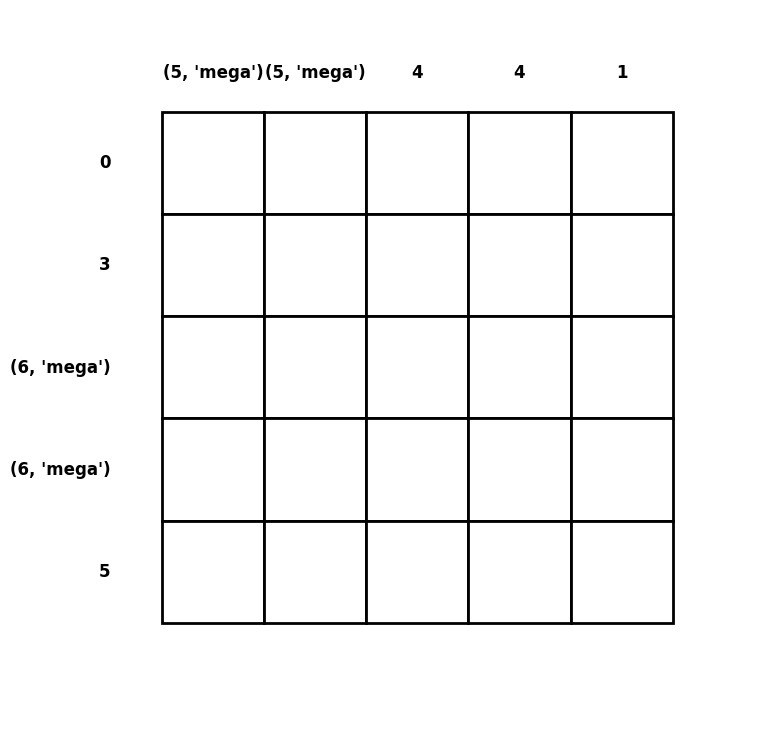

In [14]:
# Función para dibujar el tablero vacío con pistas
def draw_empty_board(row_clues, col_clues):
    """
    Dibuja el tablero vacío del Picross mostrando las pistas
    """
    n_rows = len(row_clues)
    n_cols = len(col_clues)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-1, n_cols + 1)
    ax.set_ylim(-1, n_rows + 1)
    ax.set_aspect('equal')
    ax.axis('off')

    # Dibujar las celdas vacías
    for i in range(n_rows):
        for j in range(n_cols):
            rect = plt.Rectangle((j, n_rows - 1 - i), 1, 1,
                                 facecolor='white', edgecolor='black', linewidth=2)
            ax.add_patch(rect)

    # Dibujar pistas de filas (a la izquierda)
    for i, clue in enumerate(row_clues):
        clue_text = ' '.join(map(str, clue))
        ax.text(-0.5, n_rows - 1 - i + 0.5, clue_text,
                ha='right', va='center', fontsize=12, fontweight='bold')

    # Dibujar pistas de columnas (arriba)
    for j, clue in enumerate(col_clues):
        clue_text = '\n'.join(map(str, clue))
        ax.text(j + 0.5, n_rows + 0.3, clue_text,
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Mostrar el tablero vacío
draw_empty_board(row_clues, col_clues)

## Funciones Auxiliares

### 1. Generación de Configuraciones Válidas

Esta función genera todas las posibles configuraciones de las filas y columnas Mega, al igual que las líneas tradicionales que satisfacen las pistas dadas.

In [15]:
def normalize_clues(clues):
    """
    Normaliza las pistas para separar valores normales de mega.
    
    Returns:
        tuple: (clues_normales, indices_mega)
    """
    normal_clues = []
    mega_indices = []
    
    for i, clue in enumerate(clues):
        if isinstance(clue, tuple) and len(clue) == 2 and clue[1] == 'mega':
            normal_clues.append(clue[0])
            mega_indices.append(i)
        else:
            normal_clues.append(clue)
    
    return normal_clues, mega_indices

In [16]:
def generate_line_patterns(length, clues):
    """
    Genera todas las configuraciones válidas para una línea dado su longitud y pistas.
    Similar a la función del Kakuro que genera tuplas válidas.

    Args:
        length: Longitud de la línea (número de celdas)
        clues: Lista de números que indican los grupos consecutivos

    Returns:
        Lista de tuplas, cada una representando una configuración válida (0=vacío, 1=pintado)
    """
    # Normalizar las pistas (extraer valores sin considerar si son mega)
    normalized_clues, _ = normalize_clues(clues)
    
    if not normalized_clues or (len(normalized_clues) == 1 and normalized_clues[0] == 0):
        return [tuple([0] * length)]

    patterns = []

    def backtrack(pos, clue_idx, current_pattern):
        # Si hemos colocado todos los grupos
        if clue_idx == len(normalized_clues):
            # Completar con ceros el resto
            patterns.append(tuple(current_pattern + [0] * (length - pos)))
            return

        clue = normalized_clues[clue_idx]
        min_space_needed = sum(normalized_clues[clue_idx:]) + (len(normalized_clues) - clue_idx - 1)

        # Intentar colocar el grupo en diferentes posiciones
        for start in range(pos, length - min_space_needed + 1):
            # Añadir ceros antes del grupo
            new_pattern = current_pattern + [0] * (start - pos) + [1] * clue

            # Si no es el último grupo, añadir al menos un cero de separación
            if clue_idx < len(normalized_clues) - 1:
                new_pattern.append(0)
                backtrack(start + clue + 1, clue_idx + 1, new_pattern)
            else:
                backtrack(start + clue, clue_idx + 1, new_pattern)

    backtrack(0, 0, [])
    return patterns

In [17]:
def generate_mega_patterns(line_length, clue_value):
    """
    Genera patrones para una pista mega que se extiende por dos líneas.
    En Mega Picross, las celdas deben formar un grupo CONECTADO (adyacente horizontal o verticalmente)
    entre ambas líneas, pudiendo moverse entre ellas.
    
    Args:
        line_length: Longitud de cada línea individual
        clue_value: Número de celdas que deben estar pintadas en el grupo conectado
    
    Returns:
        Lista de tuplas donde cada tupla tiene 2*line_length elementos:
        primeros line_length elementos = línea 1, siguientes line_length = línea 2
    """
    if clue_value == 0:
        return [tuple([0] * (2 * line_length))]
    
    patterns = []
    
    def is_connected(cells, line_length):
        """Verifica si las celdas pintadas forman un grupo conectado entre ambas líneas"""
        if not cells:
            return True
        
        visited = set()
        stack = [cells[0]]
        
        while stack:
            pos = stack.pop()
            if pos in visited:
                continue
            visited.add(pos)
            
            # Obtener vecinos adyacentes (horizontal y vertical entre las dos líneas)
            row = 0 if pos < line_length else 1
            col = pos % line_length
            
            neighbors = []
            # Vecino a la izquierda
            if col > 0:
                neighbors.append(pos - 1)
            # Vecino a la derecha
            if col < line_length - 1:
                neighbors.append(pos + 1)
            # Vecino en la otra línea (misma columna)
            if row == 0:
                neighbors.append(pos + line_length)
            else:
                neighbors.append(pos - line_length)
            
            for neighbor in neighbors:
                if neighbor in cells and neighbor not in visited:
                    stack.append(neighbor)
        
        return len(visited) == len(cells)
    
    def generate_combinations(n, k):
        """Genera todas las combinaciones de k elementos de n posiciones"""
        from itertools import combinations
        return list(combinations(range(n), k))
    
    # Generar todas las posibles combinaciones de clue_value celdas
    from itertools import combinations
    all_positions = list(range(2 * line_length))
    
    for combo in combinations(all_positions, clue_value):
        # Verificar si las celdas seleccionadas forman un grupo conectado
        if is_connected(list(combo), line_length):
            pattern = [0] * (2 * line_length)
            for pos in combo:
                pattern[pos] = 1
            patterns.append(tuple(pattern))
    
    return patterns

### 2. Modelo CSP del Mega Picross

In [18]:
def solve_mega_picross(row_clues, col_clues):
    """
    Resuelve un Mega Picross usando Constraint Programming con OR-Tools.
    Basado en el enfoque del Kakuro y N-Queens vistos en clase.

    Args:
        row_clues: Lista de pistas para cada fila
        col_clues: Lista de pistas para cada columna

    Returns:
        Matriz numpy con la solución (0=vacío, 1=pintado) o None si no hay solución
    """
    n_rows = len(row_clues)
    n_cols = len(col_clues)

    # Crear el modelo
    model = cp_model.CpModel()

    # Crear variables: una por cada celda (0=vacío, 1=pintado)
    grid = {}
    for i in range(n_rows):
        for j in range(n_cols):
            grid[(i, j)] = model.NewIntVar(0, 1, f'cell_{i}_{j}')

    # Identificar filas y columnas mega
    mega_row_pairs = {}
    mega_col_pairs = {}
    
    for i, clue in enumerate(row_clues):
        _, mega_indices = normalize_clues(clue)
        if mega_indices:
            mega_row_pairs[i] = mega_indices
    
    for j, clue in enumerate(col_clues):
        _, mega_indices = normalize_clues(clue)
        if mega_indices:
            mega_col_pairs[j] = mega_indices

    # Restricciones para las filas normales (no mega)
    for i, clue in enumerate(row_clues):
        if i not in mega_row_pairs:
            row_vars = [grid[(i, j)] for j in range(n_cols)]
            valid_patterns = generate_line_patterns(n_cols, clue)
            model.AddAllowedAssignments(row_vars, valid_patterns)

    # Restricciones para las columnas normales (no mega)
    for j, clue in enumerate(col_clues):
        if j not in mega_col_pairs:
            col_vars = [grid[(i, j)] for i in range(n_rows)]
            valid_patterns = generate_line_patterns(n_rows, clue)
            model.AddAllowedAssignments(col_vars, valid_patterns)

    # Restricciones para filas mega (considerar dos filas adyacentes)
    processed_mega_rows = set()
    for i in sorted(mega_row_pairs.keys()):
        if i in processed_mega_rows:
            continue
        
        # Buscar la fila adyacente con el mismo valor mega
        if i + 1 < n_rows and i + 1 in mega_row_pairs:
            # Generar patrones combinados para ambas filas como una secuencia continua
            combined_vars = [grid[(i, j)] for j in range(n_cols)] + [grid[(i+1, j)] for j in range(n_cols)]
            
            # Obtener el valor de la pista mega
            normalized_clues, _ = normalize_clues(row_clues[i])
            clue_value = normalized_clues[0] if normalized_clues else 0
            
            # Generar patrones válidos para la secuencia mega
            valid_patterns = generate_mega_patterns(n_cols, clue_value)
            model.AddAllowedAssignments(combined_vars, valid_patterns)
            
            processed_mega_rows.add(i)
            processed_mega_rows.add(i + 1)

    # Restricciones para columnas mega (considerar dos columnas adyacentes)
    processed_mega_cols = set()
    for j in sorted(mega_col_pairs.keys()):
        if j in processed_mega_cols:
            continue
        
        # Buscar la columna adyacente con el mismo valor mega
        if j + 1 < n_cols and j + 1 in mega_col_pairs:
            # Generar patrones combinados para ambas columnas como una secuencia continua
            combined_vars = [grid[(i, j)] for i in range(n_rows)] + [grid[(i, j+1)] for i in range(n_rows)]
            
            # Obtener el valor de la pista mega
            normalized_clues, _ = normalize_clues(col_clues[j])
            clue_value = normalized_clues[0] if normalized_clues else 0
            
            # Generar patrones válidos para la secuencia mega
            valid_patterns = generate_mega_patterns(n_rows, clue_value)
            model.AddAllowedAssignments(combined_vars, valid_patterns)
            
            processed_mega_cols.add(j)
            processed_mega_cols.add(j + 1)

    # Resolver
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Extraer la solución
        solution = np.zeros((n_rows, n_cols), dtype=int)
        for i in range(n_rows):
            for j in range(n_cols):
                solution[i, j] = solver.Value(grid[(i, j)])
        return solution
    else:
        return None

In [19]:
# Resolver el Mega Picross
solution = solve_mega_picross(row_clues, col_clues)

if solution is not None:
    print("¡Solución encontrada!")
    print(solution)
else:
    print("No se encontró solución.")

¡Solución encontrada!
[[0 0 0 0 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [1 1 1 1 1]]


### 3. Visualización de la Solución del Mega Picross

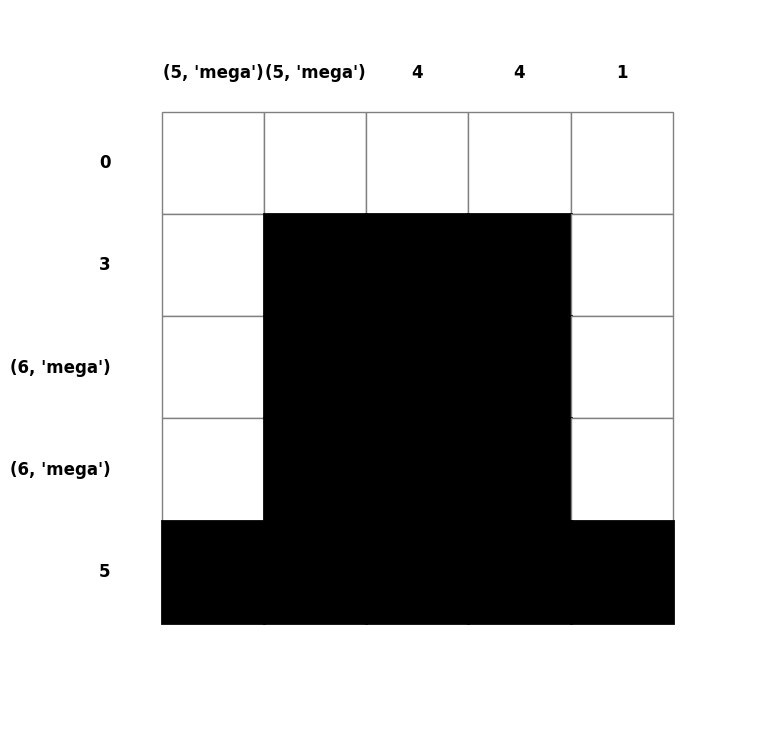

In [20]:
def draw_solution(solution, row_clues, col_clues):
    """
    Dibuja la solución del Picross.
    Basado en la visualización del N-Queens vista en clase.

    Args:
        solution: Matriz numpy con la solución
        row_clues: Pistas de las filas
        col_clues: Pistas de las columnas
    """
    n_rows, n_cols = solution.shape

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-1, n_cols + 1)
    ax.set_ylim(-1, n_rows + 1)
    ax.set_aspect('equal')
    ax.axis('off')

    # Dibujar las celdas
    for i in range(n_rows):
        for j in range(n_cols):
            if solution[i, j] == 1:
                # Celda pintada - negro
                rect = plt.Rectangle((j, n_rows - 1 - i), 1, 1,
                                     facecolor='black', edgecolor='black', linewidth=2)
            else:
                # Celda vacía - blanco con borde
                rect = plt.Rectangle((j, n_rows - 1 - i), 1, 1,
                                     facecolor='white', edgecolor='gray', linewidth=1)
            ax.add_patch(rect)

    # Dibujar pistas de filas
    for i, clue in enumerate(row_clues):
        clue_text = ' '.join(map(str, clue))
        ax.text(-0.5, n_rows - 1 - i + 0.5, clue_text,
                ha='right', va='center', fontsize=12, fontweight='bold')

    # Dibujar pistas de columnas
    for j, clue in enumerate(col_clues):
        clue_text = '\n'.join(map(str, clue))
        ax.text(j + 0.5, n_rows + 0.3, clue_text,
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Visualizar la solución
if solution is not None:
    draw_solution(solution, row_clues, col_clues)

---

## Análisis de la solución Mega Picross

### Verificación manual de las restricciones

La solución encontrada debe cumplir todas las restricciones. Verifiquemos las más interesantes:

#### 1. Restricción Mega de Filas (2-3): `[6*]`

**Pista:** 6 celdas conectadas entre filas 2 y 3

**Solución en estas filas:**
```
Fila 2: [0, 1, 1, 1, 0]  → 3 celdas pintadas
Fila 3: [0, 1, 1, 1, 0]  → 3 celdas pintadas
```

**Verificación:**
- Total: 3 + 3 = **6 celdas** ✓
- Posiciones: (2,1), (2,2), (2,3), (3,1), (3,2), (3,3)
- **Conectividad:** Todas están conectadas verticalmente por la columna 1, 2 y 3 ✓

#### 2. Restricción Mega de Columnas (0-1): `[5*]`

**Pista:** 5 celdas conectadas entre columnas 0 y 1

**Solución en estas columnas:**
```
          Col 0  Col 1
Fila 0:    0      0
Fila 1:    0      1
Fila 2:    0      1
Fila 3:    0      1
Fila 4:    1      1
```

### Diferencia clave: Mega vs Regular

**En Picross Regular:**
- La pista `[5]` en una columna significa: 5 celdas **consecutivas en línea recta**
- La única flexibilidad es **dónde empieza** la secuencia

**En Mega Picross:**
- La pista `[5*]` entre dos columnas significa: 5 celdas **conectadas de cualquier forma** entre ambas columnas
- Las celdas pueden formar patrones como:
  - Líneas horizontales
  - Líneas verticales
  - Formas de L, T, zigzag
  - Cualquier forma conexa

### Complejidad computacional

**Número de patrones generados:**
- Para una pista regular `[5]` en una línea de longitud 5: **1 patrón** (toda la línea)
- Para una pista mega `[5*]` entre dos líneas de longitud 5: **44 patrones** (todas las formas conexas posibles)

Esto muestra por qué el Mega Picross es computacionalmente más desafiante: el espacio de búsqueda es exponencialmente mayor.

---

## Conclusiones y Comparación

### Resumen de técnicas utilizadas

| Aspecto | Picross Regular | Mega Picross |
|---------|----------------|--------------|
| **Tipo de restricciones** | Una línea a la vez | Pares de líneas adyacentes |
| **Patrón de grupos** | Secuencias lineales consecutivas | Grupos conectados (pueden serpentear) |
| **Generación de patrones** | Backtracking simple | Combinatoria + verificación de conectividad |
| **Complejidad** | O(n×m) patrones típicamente | Exponencial en casos mega |
| **Algoritmo clave** | `generate_line_patterns()` | `generate_mega_patterns()` con DFS |

### Estrategias de resolución aplicadas

1. **Constraint Programming (CP-SAT de Google OR-Tools)**
   - Modelado declarativo del problema
   - Variables binarias para representar celdas
   - Restricciones expresadas como patrones permitidos
   - Búsqueda inteligente con propagación de restricciones

2. **Generación de patrones válidos**
   - Enumerar todas las configuraciones posibles
   - Filtrar solo las que satisfacen las restricciones
   - Optimización: pre-computar y cachear patrones

3. **Verificación de conectividad (solo Mega)**
   - Depth-First Search (DFS) con stack
   - Complejidad: O(k) donde k = número de celdas pintadas
   - Verifica que todas las celdas formen un componente conexo

---

## Declaración de Uso de IA:
- Servicio: GitHub Copilot
Uso de IA:
Se utilizó la IA para encontrar los notebooks trabajados en clase que mejor podían servir de referencia para el desarrollo de este proyecto, siendo: NQueens_AllDiff.ipynb y el ejercicio de Kakuro desarrollado en la PC1

También se solicitó orientación para:
- La implementación de verificación de componentes conexos usando DFS para el Mega Picross.
- Separación de pistas regulares, color y mega (dependiendo del ejercicio)
- Modificación para manejar restricciones sobre pares de líneas adyacentes
- Documentación del código dentro del notebook de manera intuitiva y dinámica



---

**¡Gracias por explorar el fascinante mundo del Picross con Constraint Programming! 🎯🧩**